In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler,RobustScaler
from sklearn.feature_selection import SelectKBest, chi2,f_classif,f_regression,mutual_info_,mutual_info_classif,mutual_info_regression,rfe

In [2]:
from collections import Counter

##### load data

In [3]:
with open("./data/zhengqi_train.txt")  as file:
    train=pd.read_table(file, sep="\t")
with open("./data/zhengqi_test.txt") as file:
    test=pd.read_table(file, sep="\t")

##### outlier detect

In [26]:
def detect_outliers(df, n, feature_name):
    outlier_indices=[]
    for col in feature_name:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        # interquartile range(IQR)
        IQR = Q3 - Q1
        outlier_step = 2 * IQR
        # Determine a list of indeices of ouliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index.tolist()
        print(col, len(outlier_list_col))
        # append the found oulier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

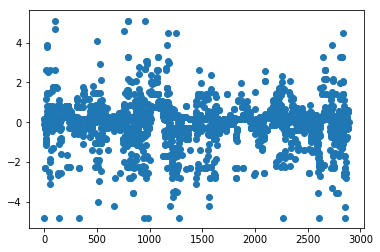

In [80]:
plt.scatter(train.index, train["V34"])

##### select outliers manually

In [4]:
# multi_outliers = detect_outliers(train, 2, train.columns)
outlier = train[ 
      # LOWER LIMIT
      (train["V0"]<-3) | 
      (train["V1"]<-3.5) | 
      (train["V2"]<-2) | 
      (train["V3"]<-3) | 
      (train["V4"]<-3.5) |
      (train["V6"]<-3.5) |
      (train["V7"]<-4) | 
      (train["V8"]<-3) | 
      (train["V9"]<-6) |
      (train["V11"]<-3) | 
      (train["V12"]<-3.5) |
      (train["V13"]<-3) | 
      (train["V15"]<-2.5) |
      (train["V16"]<-4.5) |
      (train["V17"]<-2) |
      (train["V19"]<-3) |
      (train["V20"]<-3) | 
      (train["V25"]<-3) |
      (train["V26"]<-4) |
      (train["V27"]<-1) |
      (train["V28"]<-2) |
      (train["V29"]<-2.5) |
      (train["V30"]<-2) |
      (train["V31"]<-4) |
      (train["V32"]<-2) | 
      (train["V33"]<-4) |
      (train["V34"]<-3) |
      (train["V35"]<-4) |
      (train["V37"]<-3) |
      # UPPER LIMIT
      (train["V10"]>3) | 
      (train["V15"]>3.5) |
      (train["V17"]>1.5) |
      (train["V18"]>3.5) |
      (train["V19"]>3) |
      (train["V20"]>2.5) |
      (train["V24"]>2) |
      (train["V25"]>5) |
      (train["V28"]>3.5) |
      (train["V29"]>4) |
      (train["V33"]>4) |
      (train["V34"]>4) |
      (train["V36"]>3)].index.tolist()

In [5]:
train = train.drop(outlier)

In [6]:
target = train["target"]
train.drop(["target"],axis=1,inplace=True)

In [7]:
minmax_scale = MinMaxScaler()
train_mm = minmax_scale.fit_transform(train)
test_mm = minmax_scale.transform(test)

In [8]:
train_mm = pd.DataFrame(train_mm, columns=train.columns)
test_mm = pd.DataFrame(test_mm, columns=test.columns)

In [9]:
train_mm.drop(["V5","V9","V11","V17","V22","V28"], axis=1, inplace=True)
test_mm.drop(["V5","V9","V11","V17","V22","V28"], axis=1, inplace=True)

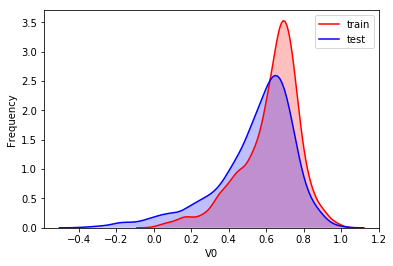

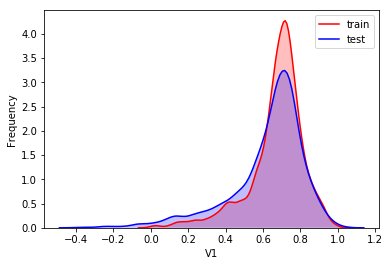

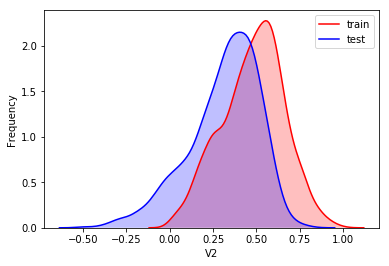

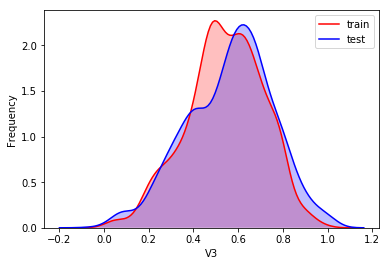

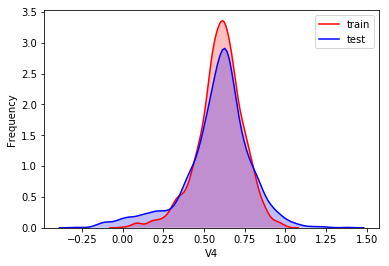

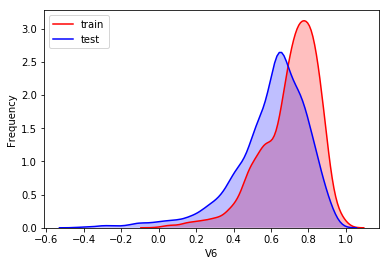

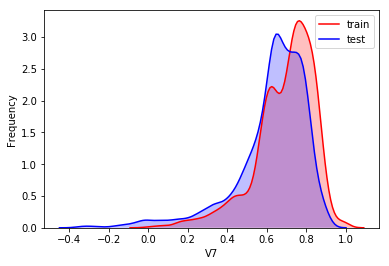

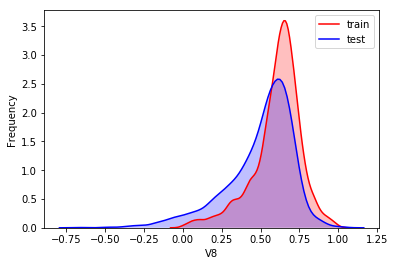

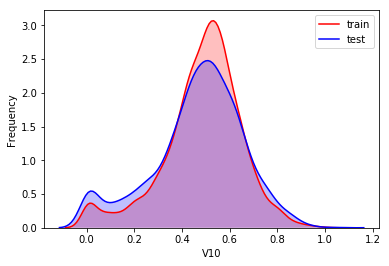

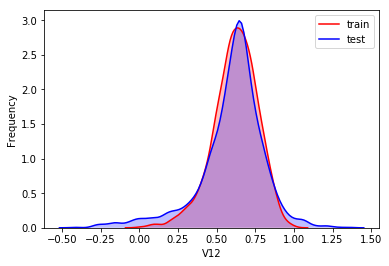

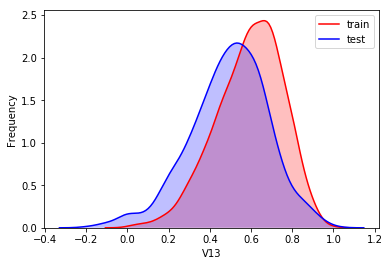

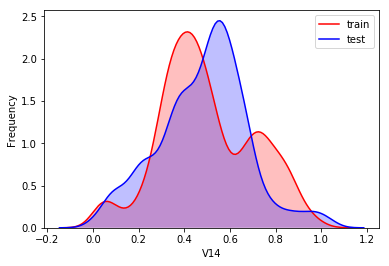

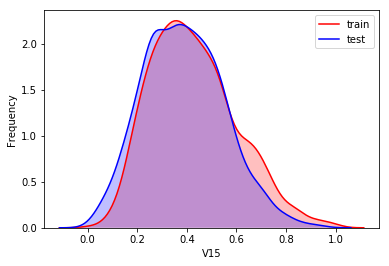

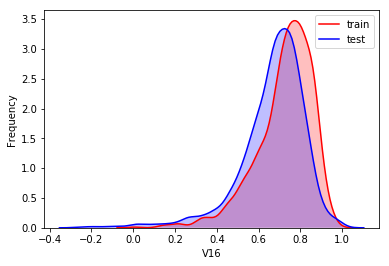

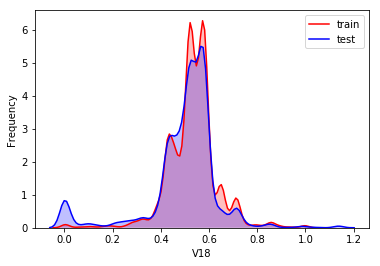

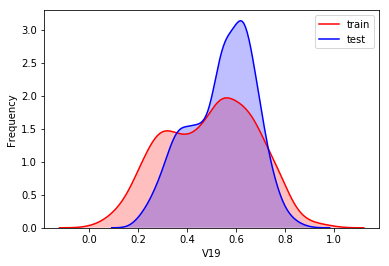

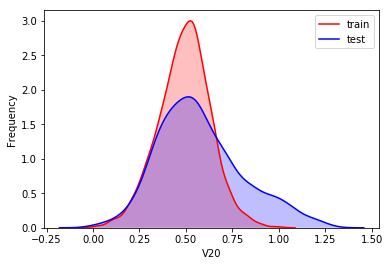

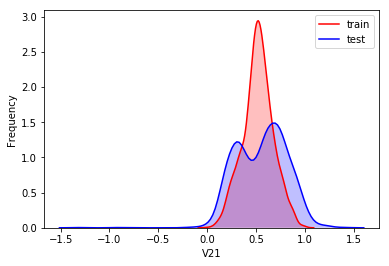

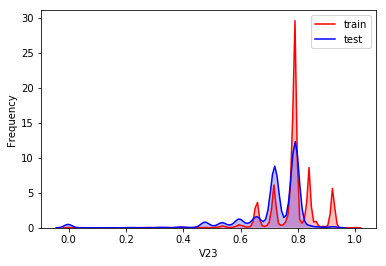

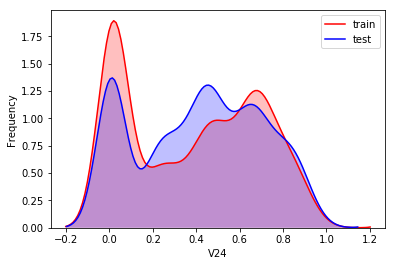

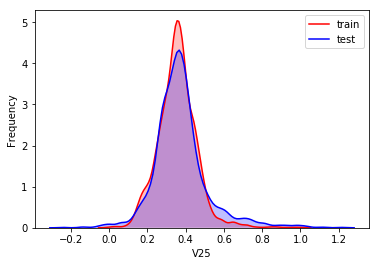

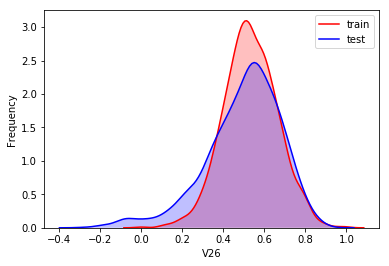

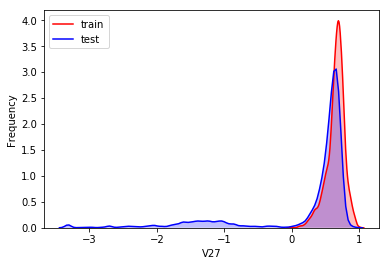

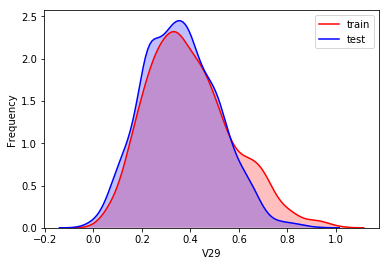

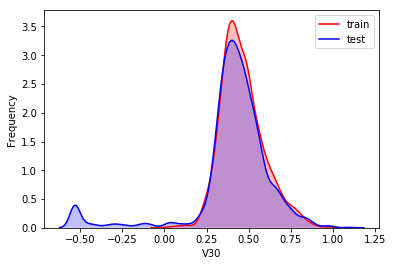

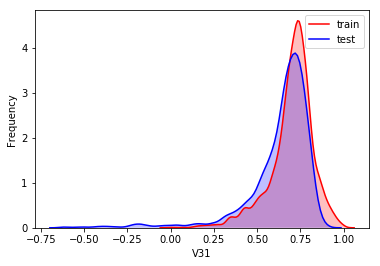

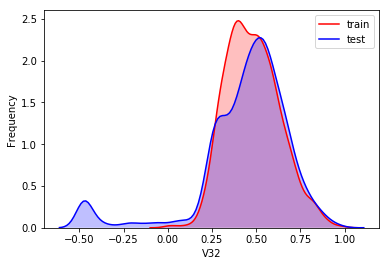

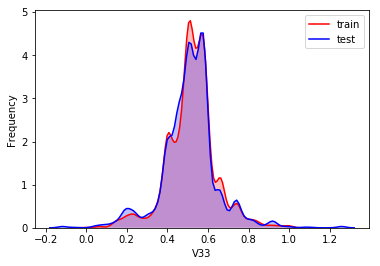

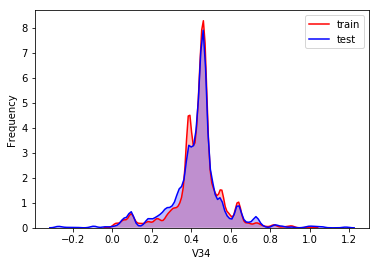

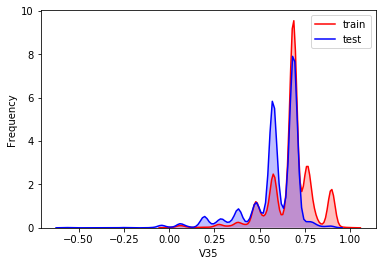

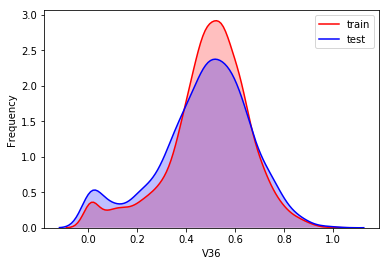

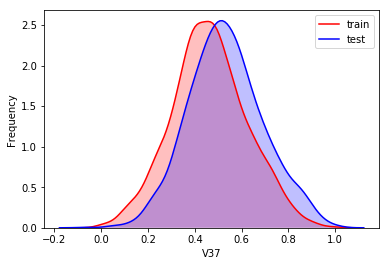

In [95]:
for column in train_mm.columns:
    g = sns.kdeplot(train_mm[column], color="Red", shade = True)
    g = sns.kdeplot(test_mm[column], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

##### modify skewness distribution manually

In [10]:
# BIAS
train_mm["V0"] = train_mm["V0"] - 0.05
train_mm["V13"] = train_mm["V13"]-0.09
train_mm["V2"] = train_mm["V2"]-0.1
train_mm["V3"] = train_mm["V3"] + 0.05
train_mm["V6"] = train_mm["V6"] - 0.06
train_mm["V7"] = train_mm["V7"]-0.05
train_mm["V8"] = train_mm["V8"]-0.04
train_mm["V14"] = train_mm["V14"]+0.08
train_mm["V16"] =train_mm["V16"]-0.04
train_mm["V19"] = train_mm["V19"]+0.05
train_mm["V37"] =train_mm["V37"]+0.06

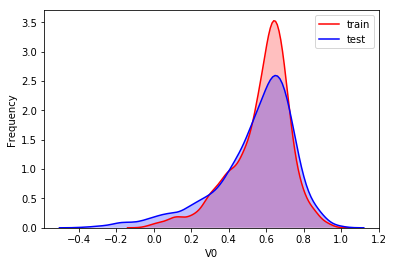

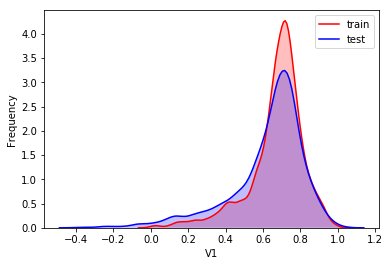

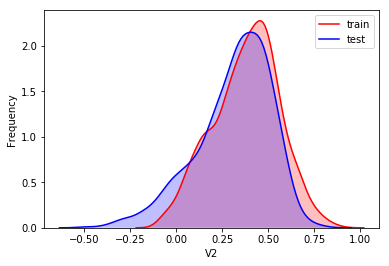

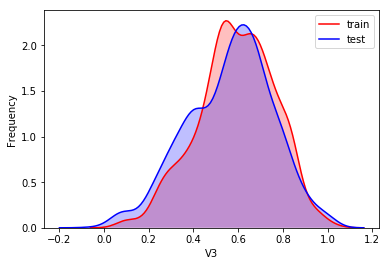

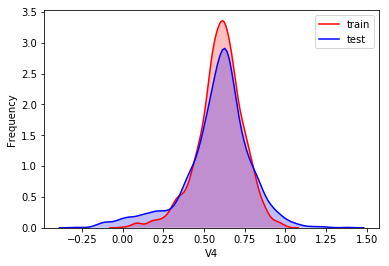

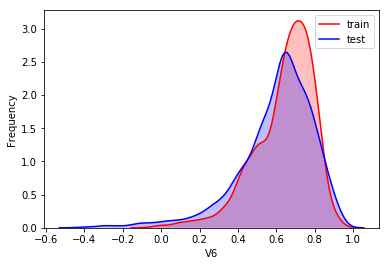

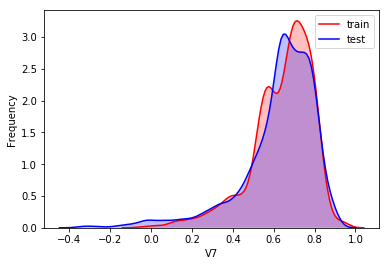

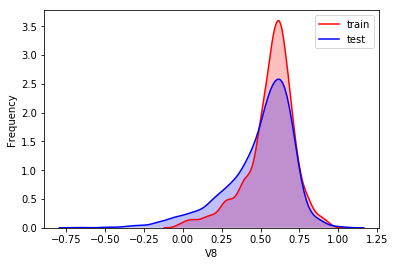

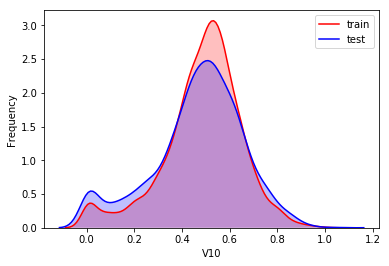

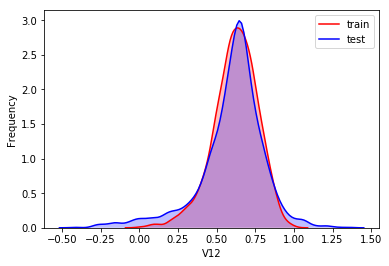

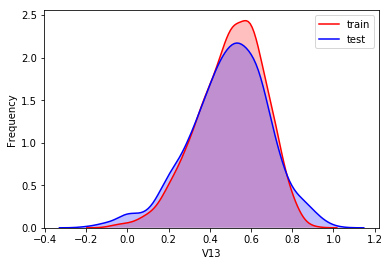

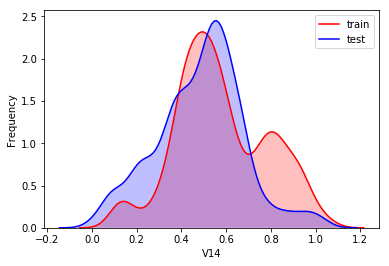

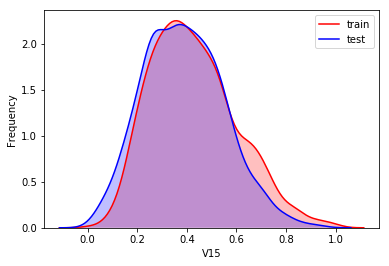

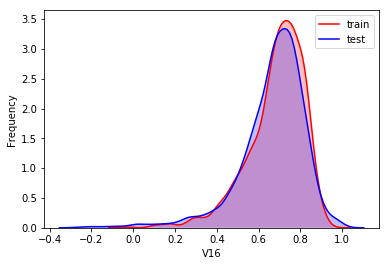

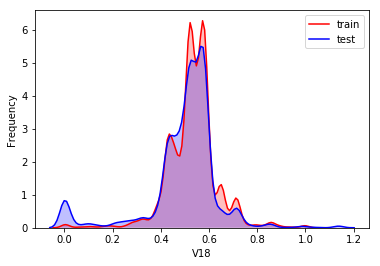

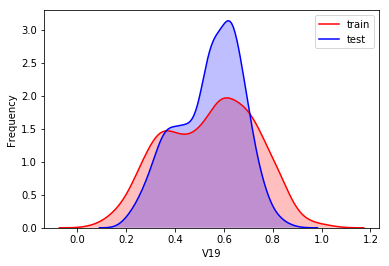

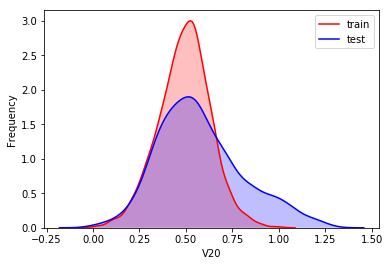

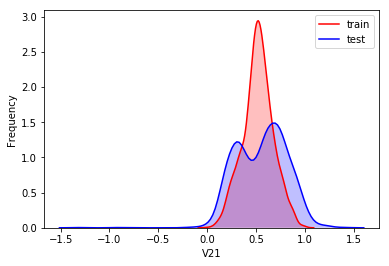

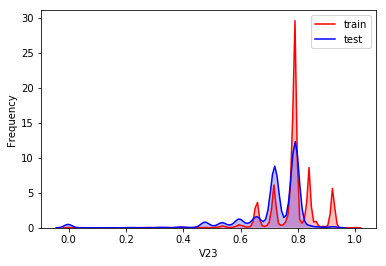

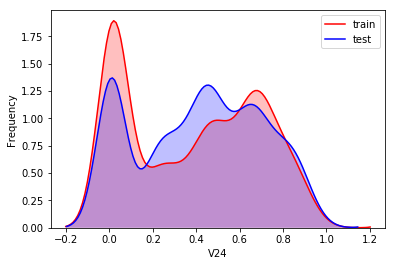

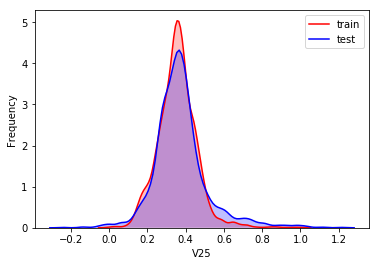

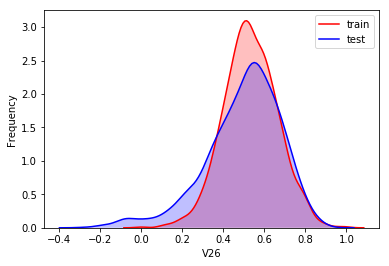

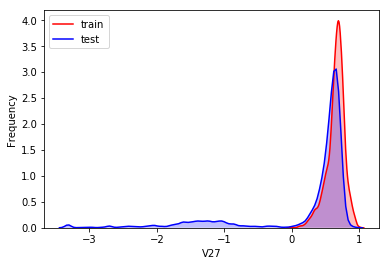

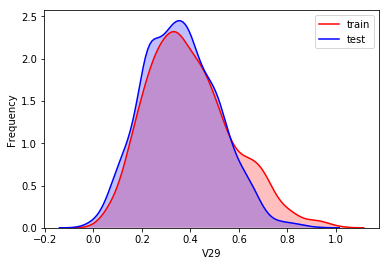

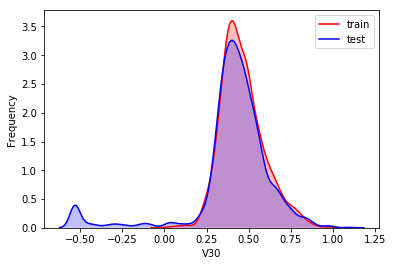

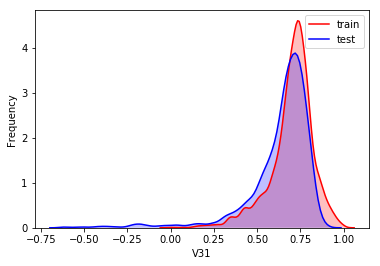

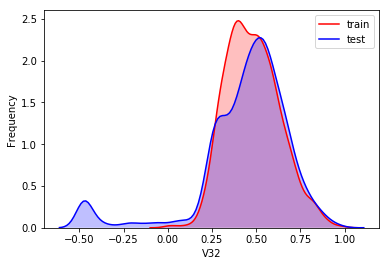

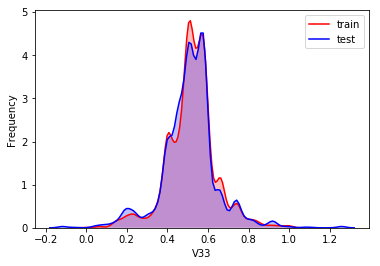

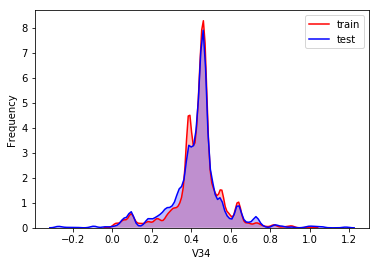

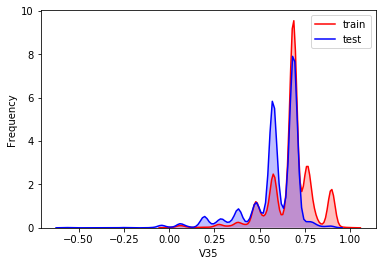

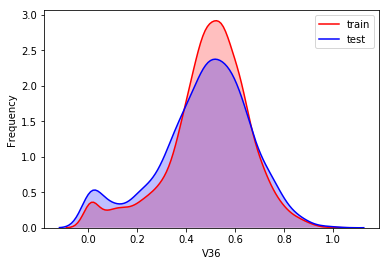

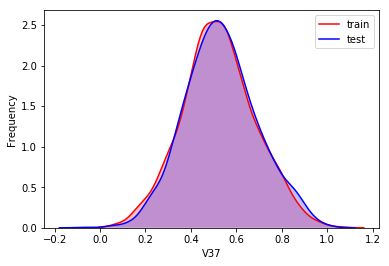

In [97]:
for column in train_mm.columns:
    g = sns.kdeplot(train_mm[column], color="Red", shade = True)
    g = sns.kdeplot(test_mm[column], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

In [11]:
# modify positive skewness distribution
for col in ["V0","V1","V2","V6", "V7", "V8", "V10", "V13", "V16", "V18","V19","V26","V31","V32","V36"]:
    train_mm[col] = np.expm1(train_mm[col])
    test_mm[col] = np.expm1(test_mm[col])
# modify neg skewness distribution
for col in ["V15", "V24","V29" ]:
    train_mm[col] = np.log1p(train_mm[col])
    test_mm[col] = np.log1p(test_mm[col])

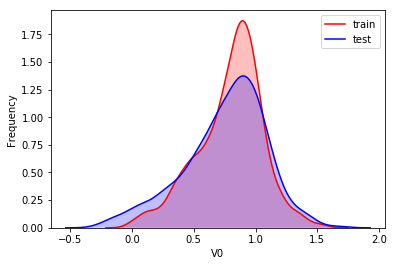

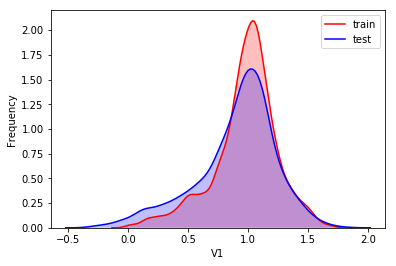

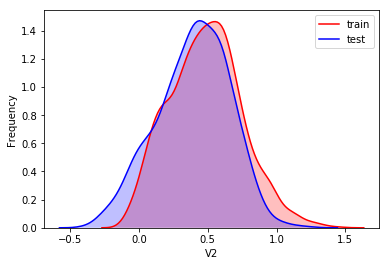

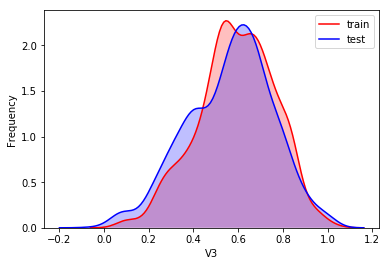

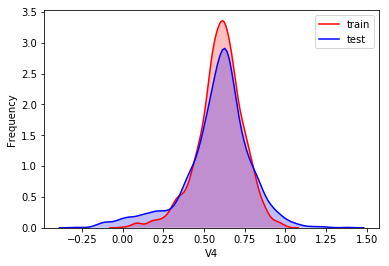

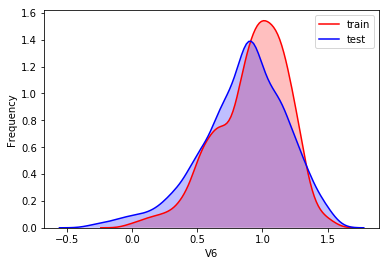

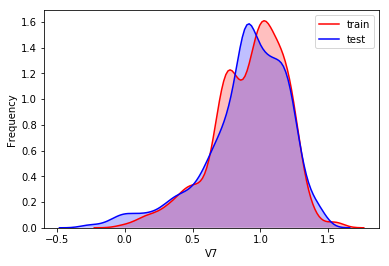

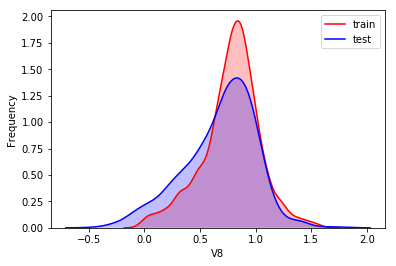

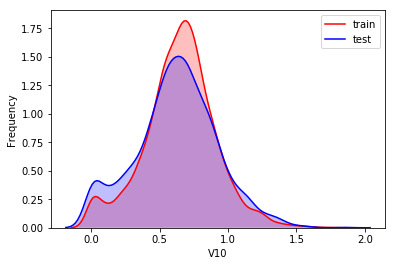

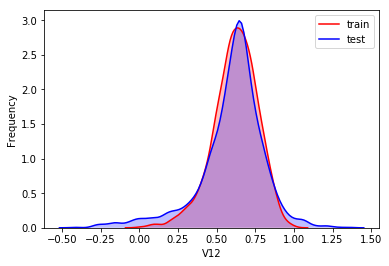

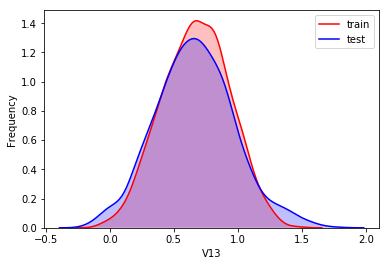

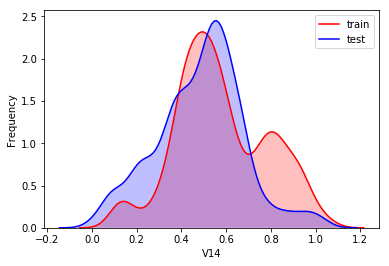

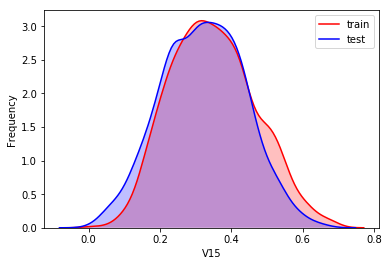

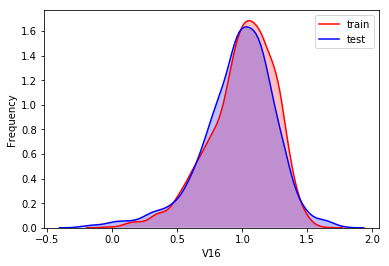

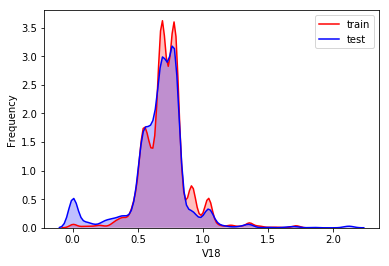

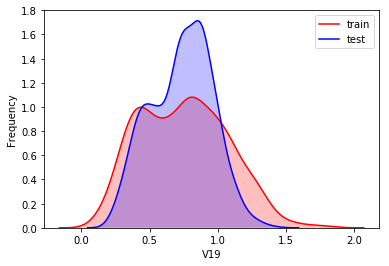

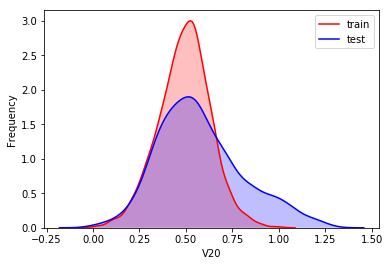

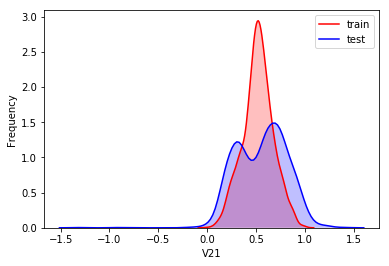

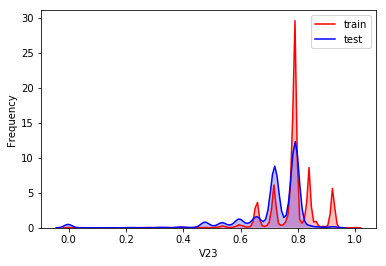

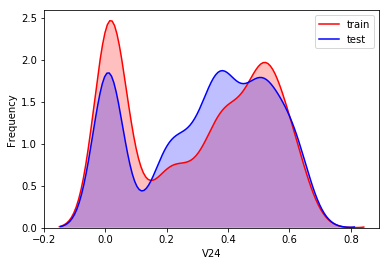

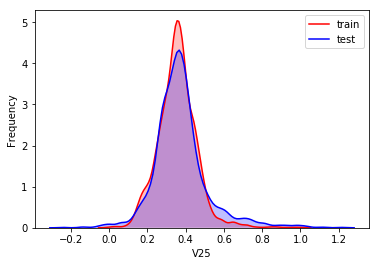

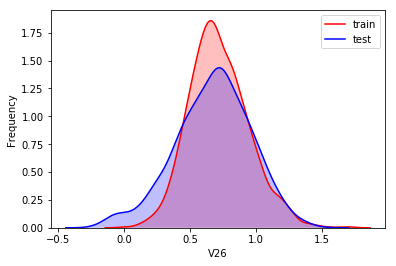

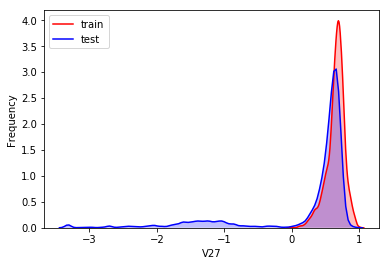

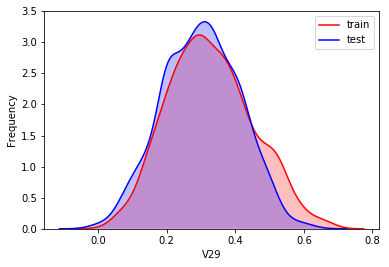

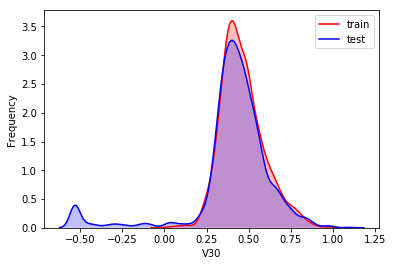

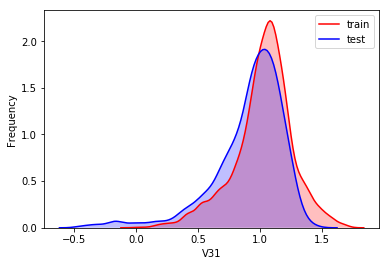

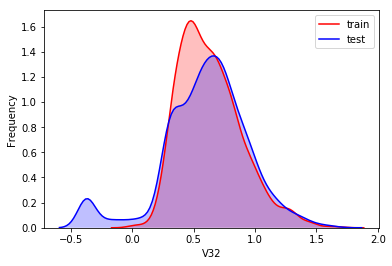

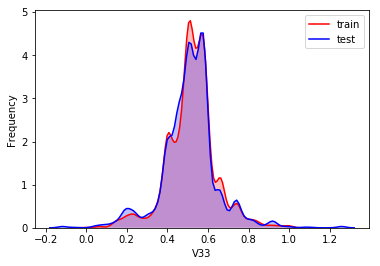

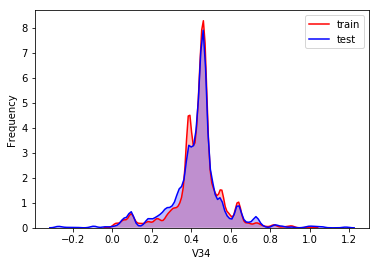

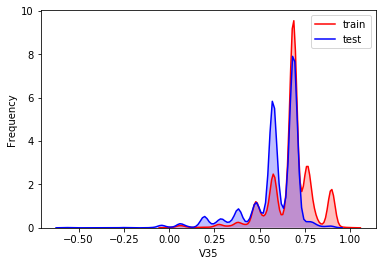

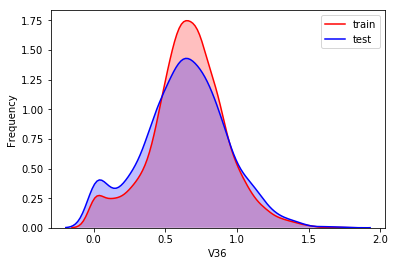

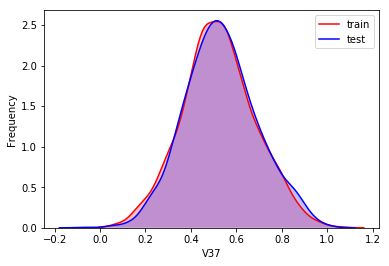

In [99]:
for column in train_mm.columns:
    g = sns.kdeplot(train_mm[column], color="Red", shade = True)
    g = sns.kdeplot(test_mm[column], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

In [12]:
# target distribution 
target_scale = MinMaxScaler()
target_mm = target_scale.fit_transform(target.values.reshape(-1,1))
# target_mm_exp = np.expm1(target_mm).reshape(-1,)

##### Standarization

In [13]:
std_scale = StandardScaler()

train_mm_std = std_scale.fit_transform(train_mm)

test_mm_std = std_scale.transform(test_mm)

train_mm_std = pd.DataFrame(train_mm_std, columns=train_mm.columns)
test_mm_std = pd.DataFrame(test_mm_std, columns=test_mm.columns)

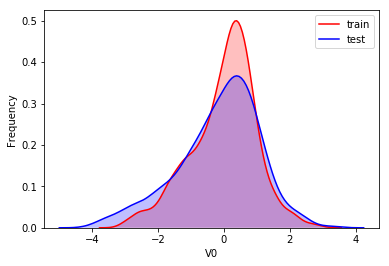

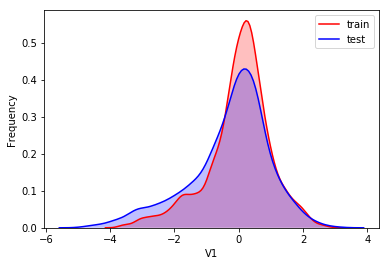

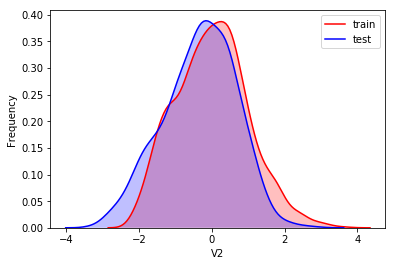

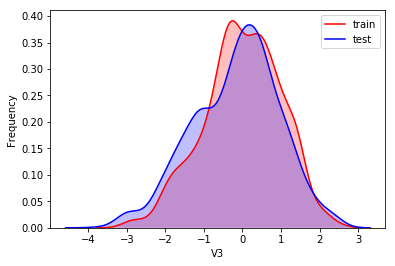

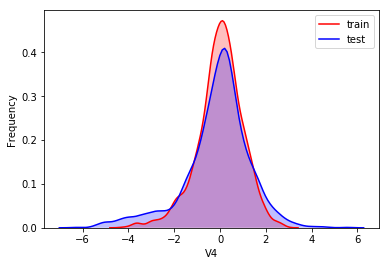

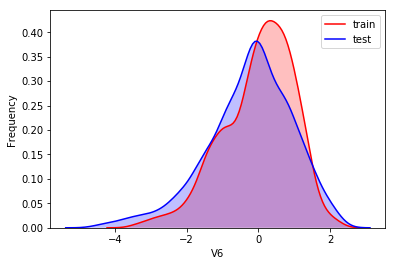

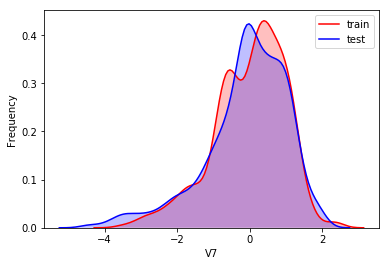

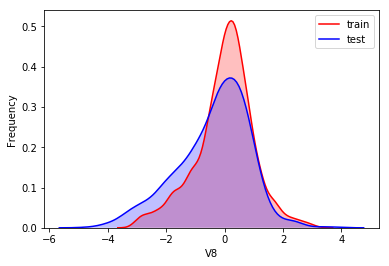

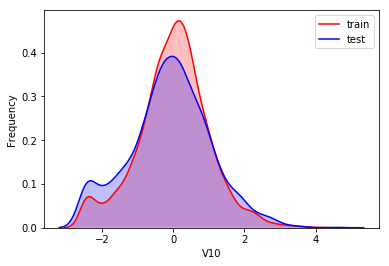

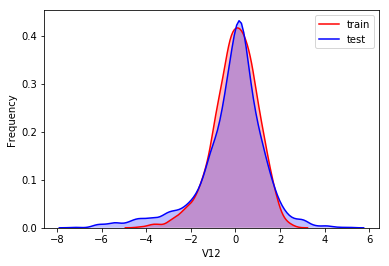

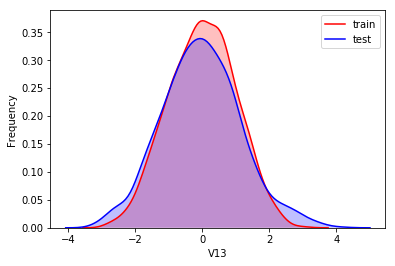

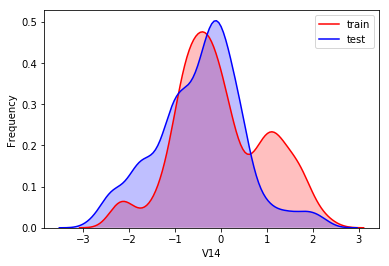

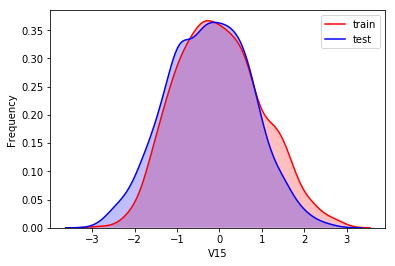

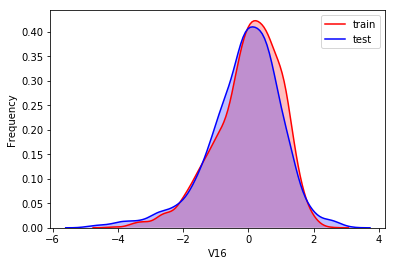

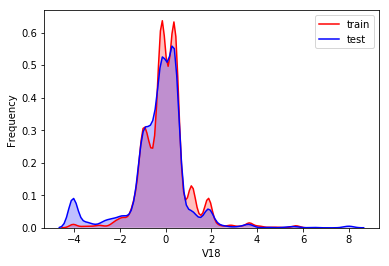

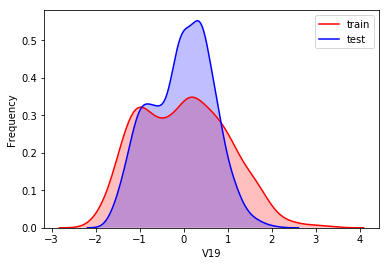

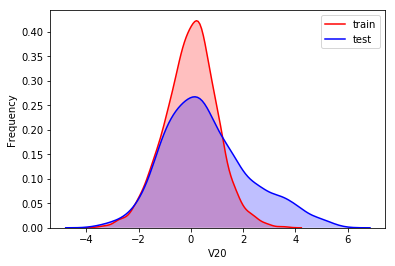

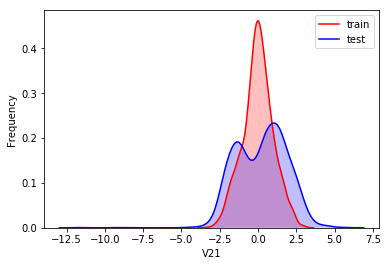

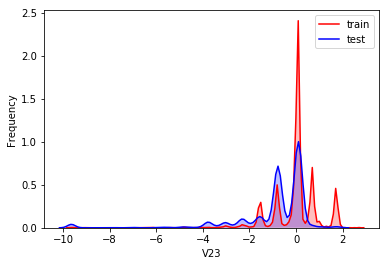

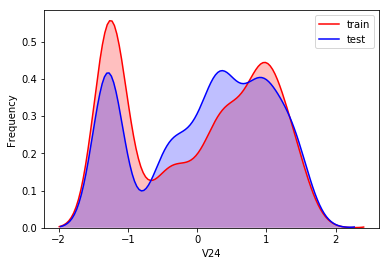

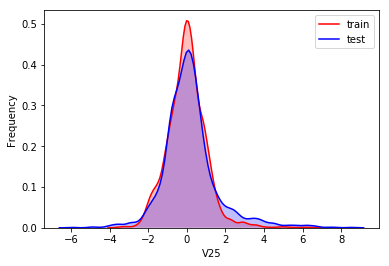

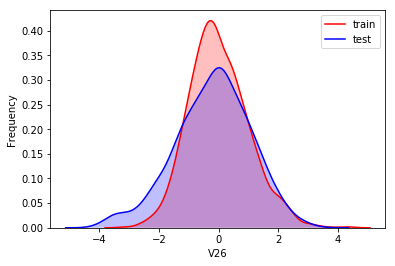

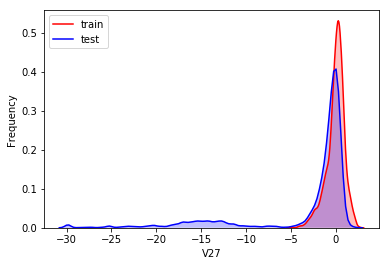

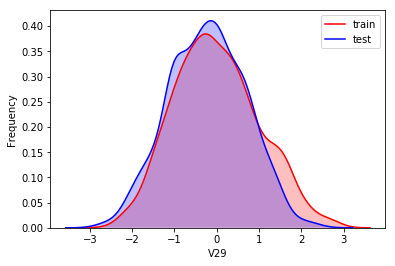

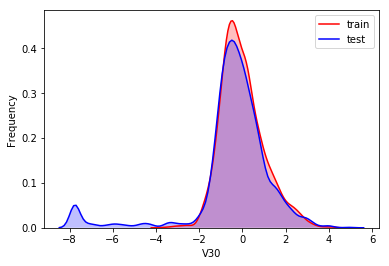

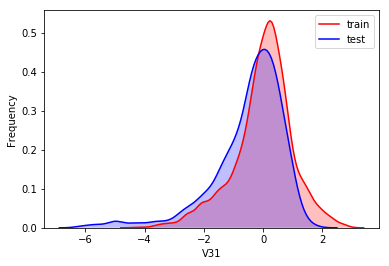

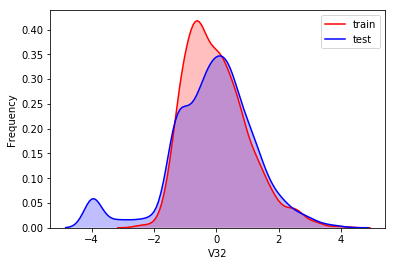

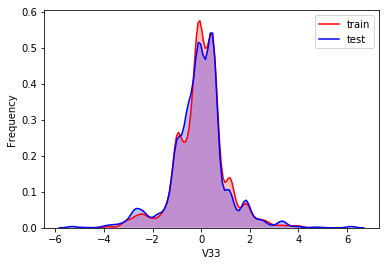

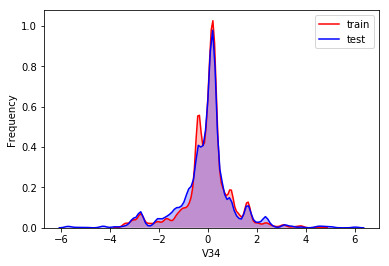

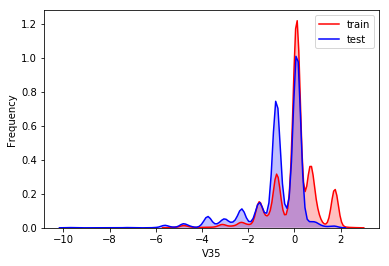

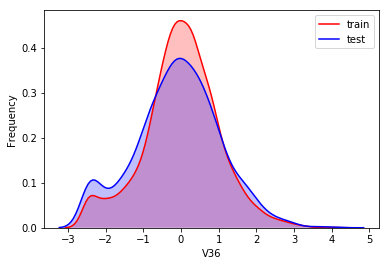

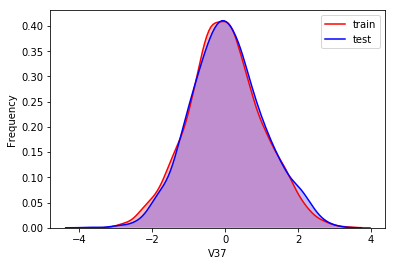

In [105]:
for column in train_mm_std.columns:
    g = sns.kdeplot(train_mm_std[column], color="Red", shade = True)
    g = sns.kdeplot(test_mm_std[column], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

##### feature selection

In [15]:
# variance selection
feature = list(train_mm.var().sort_values(ascending=False).index[:28])
train_mm_var = train_mm[feature]
test_mm_var = train_mm[feature]

In [16]:
# f1_score selection
selected = SelectKBest(score_func=f_regression, k=25)
selected.fit(train_mm_var, target)
train_mm_var_f = train_mm_var.loc[:, selected.get_support()]
test_mm_var_f = test_mm_var.loc[:, selected.get_support()]

##### Models

In [14]:
elasticNet = ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[0.001, 0.005, 0.01,0.02,0.05, 0.1, 0.5, 0.9, 0.99,2,3,4,5], cv=5 ,max_iter=5000)

In [15]:
elasticNet.fit(train_mm_std, target_mm)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 0.9, 0.99, 2, 3, 4, 5],
       max_iter=5000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [16]:
elasticNet.alpha_, elasticNet.l1_ratio_

(0.0005, 0.5)

In [123]:
from sklearn.linear_model import ElasticNet

In [17]:
model = ElasticNet(alpha=0.0005, l1_ratio=0.5, max_iter=5000)

##### ElasticNet  model fit

In [18]:
model.fit(X=train_mm_std, y=target_mm)

ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
pred_ElasticNet = model.predict(test_mm_std)

In [21]:
pred_ElasticNet

array([ 0.58903036,  0.59431324,  0.53250703, ..., -0.04710202,
       -0.03331857,  0.08030187])

In [24]:
res = target_scale.inverse_transform(pred_ElasticNet.reshape(-1,1)).reshape(-1,)

In [29]:
with open("./data/results/handle_outlier_elasticnet.txt", "w", encoding='utf8') as file:
    for i in res:
        file.write(str(i)+"\n")
    file.close()